<a href="https://colab.research.google.com/github/rezamohammadloo/Surface_anomaly_detection_using_unsupervised_algorithms/blob/main/_Surface_Defect_Detection_Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hi, this is a project that has been done to implement some unsupervised algorhimgs for "Anomaly Detection" or "Surface Anomaly Detection" problem on an image dataset with image sizes: 128*128*3.
4 different methodes are implemented for this purpose and the result of them are evaluated by AUROC and AP techniques to identify the best one.
The first algorithm is a VAE (Varitional Autoencoer)
the second one is a regular autoencoder.
the third one is OCSVM(One-Class Support Vector Machine)
and finally the last algorithm is Isolation Forest.
Befor designing and trainin model some of the main libararies and packages have been implemented to use and some functions and variables that are in common between methodes are defined.
Let's dive in!

In [2]:
# Mounting Google Drive to access the dataset stored in my Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [60]:
# Importing necessary libraries for building and training models
import os  # For operating system dependent functionality
import numpy as np  # For numerical operations and array manipulations
import pandas as pd  # For data manipulation and analysis
import tensorflow as tf  # For deep learning model creation and training
import matplotlib.pyplot as plt  # For plotting and visualizing data
from sklearn.svm import OneClassSVM  # For One-Class SVM, a traditional anomaly detection method
from sklearn.pipeline import Pipeline  # For creating pipelines that streamline preprocessing and model training
from tensorflow.keras.models import Model  # For building Keras models
from sklearn.ensemble import IsolationForest  # For Isolation Forest, another traditional anomaly detection method
from sklearn.preprocessing import StandardScaler  # For standardizing features by removing the mean and scaling to unit variance
from sklearn.model_selection import GridSearchCV  # For performing hyperparameter tuning using grid search
from tensorflow.keras.callbacks import EarlyStopping  # For stopping training early if the model stops improving
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from tensorflow.keras import layers, models, backend as K  # For creating layers, models, and accessing Keras backend
from sklearn.metrics import roc_auc_score, average_precision_score  # For evaluating model performance using ROC AUC and average precision
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # For converting images to arrays and loading images
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D  # For creating convolutional autoencoders

#0.General Functions and parameters
There are some finctions and varaiables that will be used in some or all of the methods.


In [4]:
# Define a function to load images from a specified directories
def load_images_from_directory(directory, target_size=(128, 128)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img = load_img(os.path.join(directory, filename), target_size=target_size)
            img_array = img_to_array(img) #/ 255.0  #Deviding by 255 in canceled here because we don't need to do it for third and furth method and we'll do it in the first and second method by hand.
            images.append(img_array)
    return np.array(images)

In [5]:
# Directories
# Specify the directories containing normal, anomaly, and mask images
normal_dir  = '/content/gdrive/MyDrive/glass-defect-sample/good'
anomaly_dir = '/content/gdrive/MyDrive/glass-defect-sample/anomaly'
mask_dir    = '/content/gdrive/MyDrive/glass-defect-sample/mask'

In [6]:
# Flatten images to vectors, it will be used for third and furth methodes
def flatten_images(images):
    return images.reshape(images.shape[0], -1)

In [7]:
# Define a function to compute reconstruction errors.
def compute_reconstruction_error(original, reconstructed):
    return np.mean(np.abs(original - reconstructed), axis=(1, 2, 3))

In [8]:
# Load data
# Load the normal, anomaly, and mask images from their respective directories
normal_images  = load_images_from_directory(normal_dir)
anomaly_images = load_images_from_directory(anomaly_dir)
mask_images    = load_images_from_directory( mask_dir )

# Print the shape of the loaded images
print("Normal Images Shape:", normal_images.shape)
print("Anomaly Images Shape:", anomaly_images.shape)
print("Mask Images Shape:", mask_images.shape)

Normal Images Shape: (157, 128, 128, 3)
Anomaly Images Shape: (40, 128, 128, 3)
Mask Images Shape: (40, 128, 128, 3)


#1.Varational Autoencoder

First we normalize loaded images to make the most use out of them.

In [9]:
#Normalizing their values to [0, 1]
normal_images  =  normal_images / 255.0
anomaly_images =  anomaly_images / 255.0
mask_images    =  mask_images / 255.0

Now it's time to design the architecture of VAE.

In [10]:
latent_dim = 32 #Dimensionality of the latent space for the Variational Autoencoder (VAE)

# Encoder model definition
def encoder_model(input_shape):
    # Define input layer
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers with ReLU activation and same padding
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Flatten the output and pass through dense layers to get z_mean and z_log_var
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)      # Mean of the latent space
    z_log_var = layers.Dense(latent_dim)(x)   # Log variance of the latent space

    # Define and return the encoder model
    return models.Model(inputs, [z_mean, z_log_var], name='encoder')

# Sampling function definition for the VAE
def sampling(args):
    # Retrieve z_mean and z_log_var from arguments
    z_mean, z_log_var = args

    # Determine batch size and dimensionality of z_mean
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]

    # Sample epsilon from normal distribution
    epsilon = K.random_normal(shape=(batch, dim))

    # Reparameterization trick: sample from the learned distribution
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Decoder model definition
def decoder_model(latent_dim, input_shape):
    # Define input layer for latent space
    latent_inputs = layers.Input(shape=(latent_dim,))

    # Dense layer to reshape and feed into convolutional layers
    x = layers.Dense((input_shape[0] // 8) * (input_shape[1] // 8) * 128, activation='relu')(latent_inputs)
    x = layers.Reshape((input_shape[0] // 8, input_shape[1] // 8, 128))(x)

    # Convolutional transpose layers for upsampling and decoding
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    # Output layer with sigmoid activation for image reconstruction
    outputs = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Define and return the decoder model
    return models.Model(latent_inputs, outputs, name='decoder')

# Define input shape for the VAE
input_shape = (128, 128, 3)

# Build the encoder model
encoder = encoder_model(input_shape)
z_mean, z_log_var = encoder.output

# Use the sampling function to obtain latent space representation
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Build the decoder model using the latent space representation
decoder = decoder_model(latent_dim, input_shape)

# Connect encoder input to decoder output to create VAE model
outputs = decoder(z)

# Define the VAE model with encoder input and decoder output
vae = models.Model(encoder.input, outputs, name='vae')


For traing this model we need to combine two different loss funcions: "binary cross entropy" and "KL-divergence".

In [11]:
# Calculate the reconstruction loss using binary cross-entropy
reconstruction_loss = tf.keras.losses.binary_crossentropy(K.flatten(encoder.input), K.flatten(outputs))
# Scale the reconstruction loss based on the input shape
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]

# Calculate the KL divergence loss
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

# Calculate the total VAE loss by combining the reconstruction and KL divergence losses
vae_loss = K.mean(reconstruction_loss + kl_loss)

# Add the VAE loss to the model
vae.add_loss(vae_loss)

# Compile the VAE model with the Adam optimizer
vae.compile(optimizer='adam')

In [12]:
# Define the history object to store training metrics
history = vae.fit(
    # Train the VAE model on normal images with normal images as both input and target
    normal_images, normal_images,
    epochs=500,  # Number of epochs for training
    batch_size=8,  # Batch size for training
    #validation_split=0.2,  # Fraction of training data to use for validation
    callbacks=EarlyStopping(  # Early stopping callback to prevent overfitting
        monitor="loss",  # Monitor validation loss
        verbose=1,  # Verbosity mode (1: progress bar, 0: silent)
        patience=6,  # Number of epochs with no improvement after which training will be stopped
        mode='min',  # Direction of improvement (minimize validation loss)
        restore_best_weights=True  # Restore the model weights from the epoch with the best validation loss
    )
)


Epoch 1/500
20/20 [==============================] - 19s 651ms/step - loss: 26085.1445
Epoch 2/500
20/20 [==============================] - 14s 707ms/step - loss: 23985.5586
Epoch 3/500
20/20 [==============================] - 14s 716ms/step - loss: 24048.7891
Epoch 4/500
20/20 [==============================] - 14s 683ms/step - loss: 23985.5566
Epoch 5/500
20/20 [==============================] - 12s 623ms/step - loss: 23622.1035
Epoch 6/500
20/20 [==============================] - 12s 597ms/step - loss: 23625.8945
Epoch 7/500
20/20 [==============================] - 14s 694ms/step - loss: 23751.9531
Epoch 8/500
20/20 [==============================] - 14s 715ms/step - loss: 23526.6582
Epoch 9/500
20/20 [==============================] - 14s 713ms/step - loss: 23467.2109
Epoch 10/500
20/20 [==============================] - 14s 719ms/step - loss: 23455.9727
Epoch 11/500
20/20 [==============================] - 12s 606ms/step - loss: 23374.2988
Epoch 12/500
20/20 [=====================

Reconstructing images using designed model in order to determice threshold

In [13]:
# Reconstruct normal and anomaly images using the trained VAE model
reconstructed_normal  = vae.predict(normal_images)
reconstructed_anomaly = vae.predict(anomaly_images)

# Compute reconstruction errors for normal and anomaly images
normal_errors  = compute_reconstruction_error(normal_images,  reconstructed_normal)
anomaly_errors = compute_reconstruction_error(anomaly_images, reconstructed_anomaly)

# Print mean reconstruction errors for normal and anomaly images
print("Mean  reconstruction  error  for normal  images :",np.mean(normal_errors))
print("Mean reconstruction error for anomalous images:", np.mean(anomaly_errors))

2/2 [==============================] - 1s 159ms/step
Mean  reconstruction  error  for normal  images : 0.021452293
Mean reconstruction error for anomalous images: 0.09324009


In [15]:
# Combine the reconstruction errors and true labels
all_errors = np.concatenate([normal_errors, anomaly_errors])
# Define a threshold to classify anomalies based on reconstruction errors
threshold = np.mean(all_errors)  # Adjust this threshold based on your specific use case

true_labels = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(anomaly_errors))])

# Predict labels based on the threshold
predicted_labels = (all_errors > threshold).astype(int)

# Calculate AUC-ROC
vae_aucroc = roc_auc_score(true_labels, all_errors)
print(f"auc_roc for VAE: {vae_aucroc:0.4f}")

# Calculate Average Precision (AP)
vae_ap = average_precision_score(true_labels, all_errors)
print(f"AP for VAE: {average_precision}")

auc_roc for VAE: 0.9239
AP for VAE: 0.787688091850614


This is the result for the first model,not so bad, but not great either, let's go the next method.

#2.Regular Autoencoder


In [ ]:
#Loading and normalizing images
normal_images  = load_images_from_directory(normal_dir) / 255.0
anomaly_images = load_images_from_directory(anomaly_dir) / 255.0
mask_images    = load_images_from_directory( mask_dir ) / 255.0


In [16]:
# Define a function to build an autoencoder model for image reconstruction.

def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)  # Input layer for images of shape input_shape

    # Encoder layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)  # Convolutional layer with 32 filters, ReLU activation, and same padding
    x = MaxPooling2D((2, 2), padding='same')(x)  # Max pooling layer with pool size (2, 2) and same padding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # Convolutional layer with 64 filters, ReLU activation, and same padding
    x = MaxPooling2D((2, 2), padding='same')(x)  # Max pooling layer with pool size (2, 2) and same padding

    # Decoder layers
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # Convolutional layer with 64 filters, ReLU activation, and same padding
    x = UpSampling2D((2, 2))(x)  # Up-sampling layer with up-sampling size (2, 2)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Convolutional layer with 32 filters, ReLU activation, and same padding
    x = UpSampling2D((2, 2))(x)  # Up-sampling layer with up-sampling size (2, 2)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Convolutional layer with 3 filters, sigmoid activation, and same padding

    # Define the autoencoder model
    autoencoder = Model(input_img, decoded)  # Create a model instance mapping input_img to decoded
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')  # Compile the model with Adam optimizer and binary cross-entropy loss

    return autoencoder  # Return the constructed autoencoder model

# Build the autoencoder model with input shape (128, 128, 3)
autoencoder = build_autoencoder(input_shape=(128, 128, 3))

# Print the summary of the autoencoder model architecture
autoencoder.summary()  # Display the model layers, shapes, and number of parameters


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        36928 

In [17]:
# Fit the autoencoder model on normal_images for image reconstruction.

history = autoencoder.fit(normal_images, normal_images,  # Train the model on normal_images for reconstruction
                          epochs=500,  # Number of training epochs
                          batch_size=8,  # Batch size for each iteration
                          verbose=1,  # Verbosity mode (1: progress bar, 0: silent)
                          callbacks=EarlyStopping(  # Early stopping callback to prevent overfitting
                              monitor="loss",  # Monitor training loss
                              verbose=1,  # Verbosity mode (1: progress bar, 0: silent)
                              patience=6,  # Number of epochs with no improvement after which training will be stopped
                              mode='min',  # Direction of improvement (minimize training loss)
                              restore_best_weights=True  # Restore the model weights from the epoch with the best training loss
                          )
                         )


Epoch 1/500
20/20 [==============================] - 14s 624ms/step - loss: 0.5290
Epoch 2/500
20/20 [==============================] - 11s 545ms/step - loss: 0.4796
Epoch 3/500
20/20 [==============================] - 10s 483ms/step - loss: 0.4777
Epoch 4/500
20/20 [==============================] - 12s 589ms/step - loss: 0.4778
Epoch 5/500
20/20 [==============================] - 11s 579ms/step - loss: 0.4760
Epoch 6/500
20/20 [==============================] - 10s 466ms/step - loss: 0.4761
Epoch 7/500
20/20 [==============================] - 12s 590ms/step - loss: 0.4762
Epoch 8/500
20/20 [==============================] - 12s 583ms/step - loss: 0.4752
Epoch 9/500
20/20 [==============================] - 9s 465ms/step - loss: 0.4758
Epoch 10/500
20/20 [==============================] - 14s 697ms/step - loss: 0.4756
Epoch 11/500
20/20 [==============================] - 12s 588ms/step - loss: 0.4757
Epoch 12/500
20/20 [==============================] - 11s 541ms/step - loss: 0.4757
Ep

In [19]:
# Predict on anomaly images
reconstructed_anomalies = autoencoder.predict(anomaly_images)

# Calculate reconstruction error
reconstruction_errors = compute_reconstruction_error(anomaly_images, reconstructed_anomalies)

# Threshold for anomaly detection (this can be tuned)
threshold = np.percentile(reconstruction_errors, 95)

# Detect anomalies
anomalies_detected = reconstruction_errors > threshold

2/2 [==============================] - 1s 208ms/step


In [64]:
# Predict on both good and anomaly images
reconstructed_good = autoencoder.predict(normal_images)
reconstructed_anomalies = autoencoder.predict(anomaly_images)

# Calculate reconstruction error for both
good_errors = compute_reconstruction_error(normal_images, reconstructed_good)
anomaly_errors = compute_reconstruction_error(anomaly_images, reconstructed_anomalies)

# Combine errors and labels
all_errors = np.concatenate([good_errors, anomaly_errors])
all_labels = np.concatenate([np.zeros(len(good_errors)), np.ones(len(anomaly_errors))])

# Compute AUROC
ae_aucroc = roc_auc_score(all_labels, all_errors)
print(f'AUROC for autoencoder: {ae_aucroc:.4f}')

# Compute Average Precision (AP)
ae_ap = average_precision_score(all_labels, all_errors)
print(f'AP for autoencoder: {ae_ap:.4f}')

2/2 [==============================] - 1s 119ms/step
AUROC for autoencoder: 0.9838
AP for autoencoder: 0.9578


Seems so much better, let's move on to the next one.

#One-class SVM

In [33]:
# Flatten the images
X_flat = normal_images.reshape(normal_images.shape[0], -1)
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)
# Train One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', nu=0.1)  # Adjust parameters as needed
ocsvm.fit(X_scaled)

anomaly_scaled = anomaly_images.reshape(anomaly_images.shape[0], -1)
anomaly_scaled = scaler.transform(anomaly_scaled)


# Predict images
all_images = np.concatenate((X_scaled, anomaly_scaled), axis=0)
all_labels = np.concatenate((np.ones(X_scaled.shape[0]) , -1*np.ones(anomaly_scaled.shape[0])))

all_prediction = ocsvm.predict(all_images)

ocsvm_aucroc = roc_auc_score(all_labels, all_prediction)
print(f"AUC-ROC for ocsvm: {ocsvm_aucroc}")

# Calculate Average Precision (AP)
ocsvm_ap = average_precision_score(all_labels, all_prediction)
print(f"AP for ocsvm: {ocsvm_ap}")



AUC-ROC for ocsvm: 0.9522292993630573
AP for ocsvm: 0.9806007307058101


#Isonation Forest
As the last mathod I leverage Isolation Forest method.

In [46]:
X_good = flatten_images(normal_images)
X_anomaly = flatten_images(anomaly_images)

In [47]:
# Scale the data
scaler = StandardScaler()
X_good = scaler.fit_transform(X_good)
X_anomaly = scaler.transform(X_anomaly)

In [48]:
# Train Isolation Forest
isolation_forest = IsolationForest( contamination='auto', random_state=42)
isolation_forest.fit(X_good)

IsolationForest(random_state=42)

In [57]:
all_images = np.concatenate((X_good, X_anomaly), axis=0)
# all_labels = np.concatenate((np.zeros(X_good.shape[0]), np.ones(X_anomaly.shape[0])))
all_labels = np.concatenate((np.ones(X_good.shape[0]) , -1*np.ones(X_anomaly.shape[0])))
predictions = isolation_forest.predict(all_images)



In [58]:
if_aucroc = roc_auc_score(all_labels, predictions)
print(f"AUC-ROC for Isolation Forest: {if_aucroc:0.04f}" )

if_ap = average_precision_score(all_labels, predictions)
print(f"AP for Isolation Forest: {if_ap:0.04f}")

AUC-ROC for Isolation Forest: 0.8363
AP for Isolation Forest: 0.9260


#Comparing methods
here we see the results all together and we can compare the easily
in a table:

In [73]:
# Define the data with specific values
data = {
    'Average Precision': [vae_ap, ae_ap, ocsvm_ap, if_ap],  # Example values for AP
    'AUCROC': [vae_aucroc, ae_aucroc, ocsvm_aucroc, if_aucroc]  # Example values for AUCROC
}
index = ['VAE', 'AE', 'OC_SVM', 'I_F']  # Index labels for the DataFrame
# Create the DataFrame with the specified values
df = pd.DataFrame(data, index=index)
# Display the DataFrame
print(df)

        Average Precision    AUCROC
VAE              0.816367  0.896815
AE               0.957828  0.983758
OC_SVM           0.980601  0.952229
I_F              0.925990  0.836306


and a bar plot:

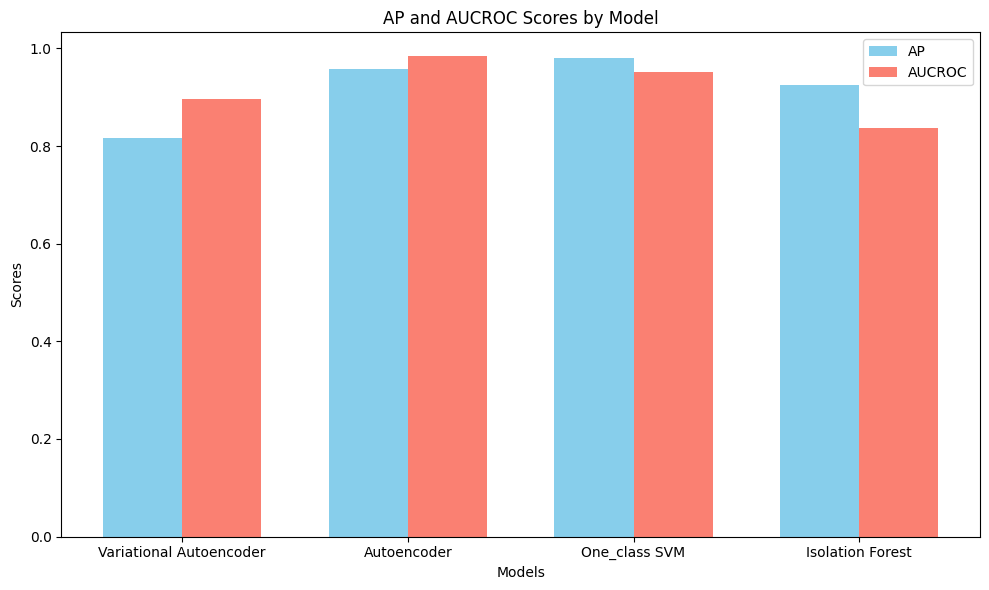

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the data with specific values
data = {
    'AP': [vae_ap, ae_ap, ocsvm_ap, if_ap],  # Example values for AP
    'AUCROC': [vae_aucroc, ae_aucroc, ocsvm_aucroc, if_aucroc]  # Example values for AUCROC
}

# Define the row indices
index = ['Variational Autoencoder', 'Autoencoder', 'One_class SVM', 'Isolation Forest']

# Create the DataFrame with the specified values
df = pd.DataFrame(data, index=index)

# Plotting the grouped bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define the bar width
bar_width = 0.35

# Define the positions of the bars on the x-axis
indices = np.arange(len(df))

# Create bars for AP
bars1 = ax.bar(indices - bar_width/2, df['AP'], bar_width, label='AP', color='skyblue')

# Create bars for AUCROC
bars2 = ax.bar(indices + bar_width/2, df['AUCROC'], bar_width, label='AUCROC', color='salmon')

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('AP and AUCROC Scores by Model')
ax.set_xticks(indices)
ax.set_xticklabels(df.index)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()
